In [48]:
# uninstall
!pip uninstall -y wandb

# download
!pip install transformers
!pip install simplet5

# import
import re
import json
import torch

import random
import pandas as pd
from tqdm import tqdm
from simplet5 import SimpleT5
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [49]:
!pip install h5py
!pip install typing-extensions
!pip install wheel

In [50]:
!pip install -q tf-models-official

In [51]:
!pip install datasets

In [52]:
import pandas as pd
from datasets import load_dataset

dataset_train = load_dataset('imdb',split='train')
#aset_train.rename_column_('label', 'labels')
train_df=pd.DataFrame(dataset_train)

dataset_test = load_dataset('imdb',split='test')
#dataset_test.rename_column_('label', 'labels')
test_df=pd.DataFrame(dataset_test)


train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [85]:
print(train_df.shape)
print(test_df.shape)

(21375, 2)
(1125, 2)


In [53]:
def pick_first_n_words(string, max_words=250): # tried a few max_words, kept 250 as max tokens was < 512
        split_str = string.split()
        return " ".join(split_str[:min(len(split_str), max_words)])

In [54]:
train_df['text'] = train_df['text'].apply(lambda x: pick_first_n_words(x))
map_label = {0:'negative', 1: 'positive'}
train_df['label'] = train_df['label'].apply(lambda x: map_label[x])

In [59]:
train_df.shape

(22500, 2)

In [55]:
test_df['text'] = test_df['text'].apply(lambda x: pick_first_n_words(x))
map_label = {0:'negative', 1: 'positive'}
test_df['label'] = test_df['label'].apply(lambda x: map_label[x])

In [56]:
    # divide into test and train
    X_train, X_test, y_train, y_test = \
              train_test_split(train_df['text'].tolist(), train_df['label'].tolist(),
              shuffle=True, test_size=0.05, random_state=1, stratify=train_df['label'])

In [57]:
    # transform to pandas dataframe
train_data = pd.DataFrame({'source_text': X_train, 'target_text': y_train})
test_data = pd.DataFrame({'source_text': X_test, 'target_text': y_test})

In [61]:
print(train_data.shape)
print(test_data.shape)

(21375, 2)
(1125, 2)


In [62]:
import time

In [63]:
from glob import glob
start_time = time.time()  # Record the start time
for trial_no in range(1):
    # create data
    #train_df, test_df = load_sentiment_dataset(trial_no)
    train_df=train_data
    test_df=test_data
    # load model
    model = SimpleT5()
    model.from_pretrained(model_type="t5", model_name="t5-small")
    # train model
    model.train(train_df=train_df,
                eval_df=test_df,
                source_max_token_len=300,
                target_max_token_len=200,
                batch_size=8,
                max_epochs=2,
                outputdir = "outputs",
                use_gpu=True
               )
    # fetch the path to last model
    last_epoch_model = None
    for file in glob("./outputs/*"):
        if 'epoch-1' in file:
            last_epoch_model = file
    # load the last model
    model.load_model("t5", last_epoch_model, use_gpu=True)
    # test and save
    # for each test data perform prediction
    predictions = []
    for index, row in test_df.iterrows():
        prediction = model.predict(row['source_text'])[0]
        predictions.append(prediction)
    df = test_df.copy()
    df['predicted'] = predictions
    df['original'] = df['target_text']
    print(f1_score(df['original'], df['predicted'], average='macro'))
    df.to_csv(f"result_run_{trial_no}.csv", index=False)
    # clean the output
    !rm -rf ./outputs
end_time = time.time()  # Record the end time
training_time = end_time - start_time  # Calculate the training time
print(f"Training time: {training_time:.2f} seconds")

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors


0.9341784842312997
Training time: 1559.91 seconds


In [64]:
print(f1_score(df['original'], df['predicted'], average='macro'))

0.9341784842312997


In [65]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [66]:
# Calculate metrics
accuracy = accuracy_score(df['original'], df['predicted'])
recall = recall_score(df['original'], df['predicted'], average='macro')
precision = precision_score(df['original'], df['predicted'], average='macro')
f1 = f1_score(df['original'], df['predicted'], average='macro')


In [67]:

    # Print metrics
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-Score: {f1}")


Accuracy: 0.9342222222222222
Recall: 0.9341261061946903
Precision: 0.9350831791804981
F1-Score: 0.9341784842312997


In [68]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

In [69]:
 # Calculate confusion matrix
cm = confusion_matrix(df['original'], df['predicted'])

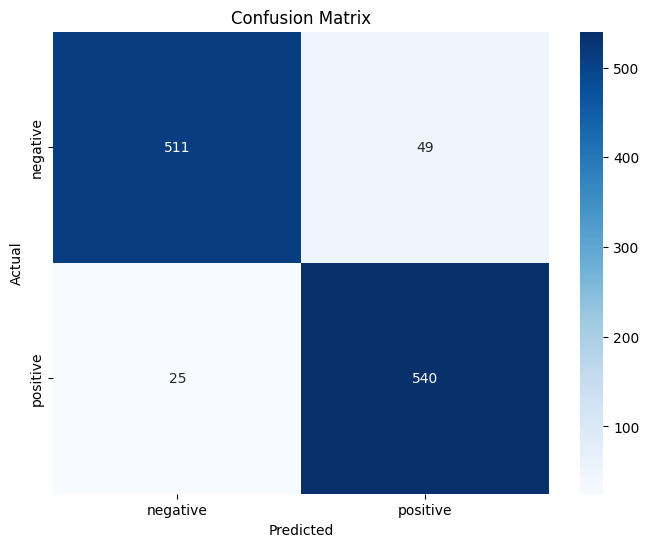

In [70]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [71]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

In [72]:
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(df['original'])
y_pred_bin = lb.transform(df['predicted'])

AUC: 0.9341261061946903


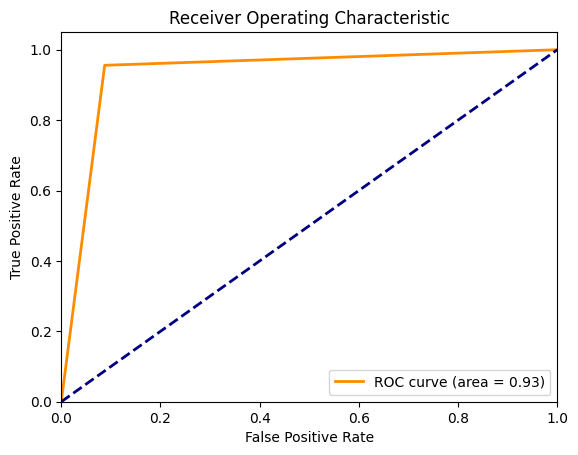

In [73]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc = auc(fpr, tpr)
# Print AUC
print(f"AUC: {roc_auc}")
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [43]:
    # Assuming you've already trained the model, loaded the last epoch model, and performed predictions
    custom_reviews = [
    'Captivating, heartwarming film. Superb acting, engaging plot. A must-watch for a feel-good experience.',  # this is the same sentence tried earlier
    'The movie was great!',
    'Dull plot, unconvincing acting. Lacks depth. Disappointing overall. Not recommended for a satisfying movie experience.',
    'Amid convoluted storytelling, insipid characters, and erratic pacing, the movie falters, failing to captivate or engage',
    'The movie was terrible...'
]

    custom_predictions = []
    for review in custom_reviews:
        prediction = model.predict(review)[0]
        custom_predictions.append(prediction)

    # Print custom review predictions
    for review, prediction in zip(custom_reviews, custom_predictions):
        print(f"Review: {review}")
        print(f"Predicted Sentiment: {prediction}\n")

Review: Captivating, heartwarming film. Superb acting, engaging plot. A must-watch for a feel-good experience.
Predicted Sentiment: positive

Review: The movie was great!
Predicted Sentiment: positive

Review: Dull plot, unconvincing acting. Lacks depth. Disappointing overall. Not recommended for a satisfying movie experience.
Predicted Sentiment: negative

Review: Amid convoluted storytelling, insipid characters, and erratic pacing, the movie falters, failing to captivate or engage
Predicted Sentiment: negative

Review: The movie was terrible...
Predicted Sentiment: negative

